In [1]:
!git clone https://github.com/calvin050101/Waste-Type-Classification.git
%cd repo

fatal: destination path 'Waste-Type-Classification' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'repo'
/content


# Importing Dataset

In [2]:
import os, pathlib, tensorflow as tf
from tensorflow import keras

In [3]:
DATA_DIR = "/content/Waste-Type-Classification/garbage_classification.zip"
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
import zipfile

# Define the directory to extract the dataset
dataset_dir = "/content/waste_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(DATA_DIR, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")

Dataset extracted to: /content/waste_dataset


# Data Preprocessing

In [5]:
IMG_PATH = "/content/waste_dataset/garbage_classification"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 6500 files belonging to 10 classes.
Using 5200 files for training.
Found 6500 files belonging to 10 classes.
Using 1300 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [8]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.05),
], name="augment")

In [12]:
from tensorflow import keras
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load MobileNet as the base model
base = MobileNet(include_top=False,
                 weights="imagenet",
                 input_shape=(224, 224, 3))
base.trainable = False   # freeze base model

# Build the model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

In [13]:
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5,
                                  restore_best_weights=True,
                                  monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.4796 - loss: 1.5734 - val_accuracy: 0.8508 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8230 - loss: 0.5272 - val_accuracy: 0.8946 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8665 - loss: 0.3863 - val_accuracy: 0.9023 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8855 - loss: 0.3351 - val_accuracy: 0.9123 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9067 - loss: 0.2829 - val_accuracy: 0.9100 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9089 - loss: 0.2682 - val_accuracy: 0.9131 - val_loss: 0.2538 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9166 - loss

In [16]:
base.trainable = True

# Fine-tune from this layer onwards
for layer in base.layers:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tuned_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.9390 - loss: 0.1782 - val_accuracy: 0.9215 - val_loss: 0.2292 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9488 - loss: 0.1468 - val_accuracy: 0.9338 - val_loss: 0.1922 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9536 - loss: 0.1359 - val_accuracy: 0.9162 - val_loss: 0.2225 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9552 - loss: 0.1292 - val_accuracy: 0.9315 - val_loss: 0.2067 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9622 - loss: 0.1076 - val_accuracy: 0.9338 - val_loss: 0.1849 - learning_rate: 5.0000e-06
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9670 - loss: 0.0983 - val_accuracy: 0.9362 - val_loss: 0.1838 - learning_rate: 5.0000e-06
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 12

# Model Evaluation

In [17]:
# Get best epoch
best_epoch = tf.math.argmax(tuned_history.history["val_accuracy"]) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 10


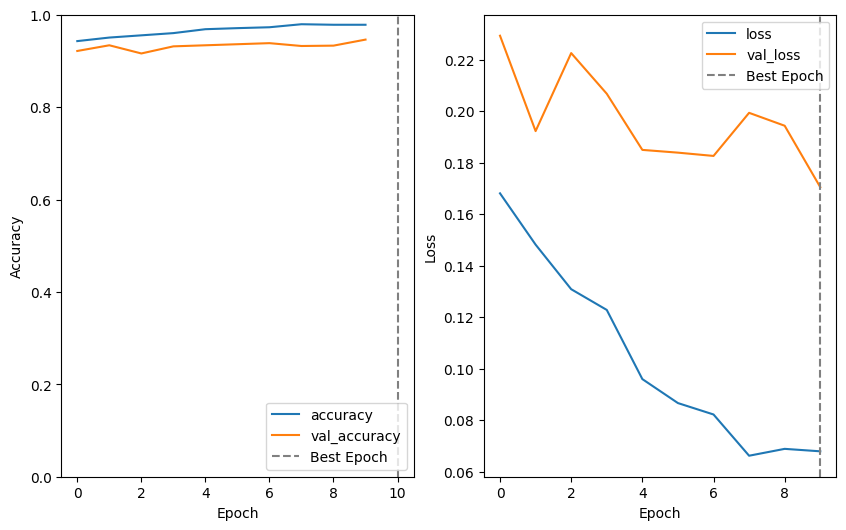

In [18]:
# Plot history graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(tuned_history.history["accuracy"], label="accuracy")
plt.plot(tuned_history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.axvline(best_epoch, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(tuned_history.history["loss"], label="loss")
plt.plot(tuned_history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axvline(best_epoch - 1, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="upper right")

plt.show()

In [19]:
import numpy as np

y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


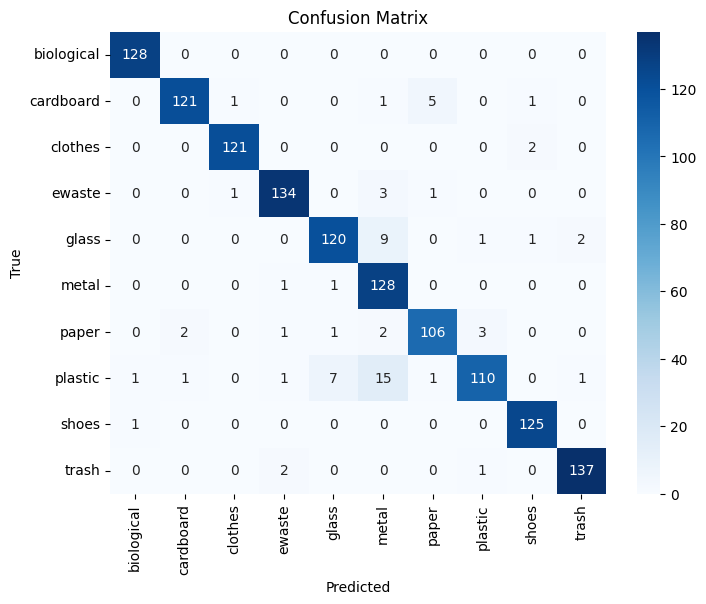

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Display the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

  biological       0.98      1.00      0.99       128
   cardboard       0.98      0.94      0.96       129
     clothes       0.98      0.98      0.98       123
      ewaste       0.96      0.96      0.96       139
       glass       0.93      0.90      0.92       133
       metal       0.81      0.98      0.89       130
       paper       0.94      0.92      0.93       115
     plastic       0.96      0.80      0.87       137
       shoes       0.97      0.99      0.98       126
       trash       0.98      0.98      0.98       140

    accuracy                           0.95      1300
   macro avg       0.95      0.95      0.95      1300
weighted avg       0.95      0.95      0.95      1300

